# Census with Modin and Intel® oneAPI Data Analytics Library (oneDAL) Accelerated Scikit-Learn and training time comparision 

In [13]:
# =============================================================
# Copyright © 2020 Intel Corporation
# 
# SPDX-License-Identifier: MIT
# =============================================================

In this example we will be building an end to end machine learning workload with US census from 1970 to 2010.
It uses Modin with Ray as backend compute engine for ETL, and uses Ridge Regression from oneDAL accelerated scikit-learn library to train and predict the US total income with education information.

Let's start by downloading census data to your local disk. <br>
Note: Skip this step if you have already downloaded the census data.

In [14]:
!wget https://storage.googleapis.com/intel-optimized-tensorflow/datasets/ipums_education2income_1970-2010.csv.gz

--2021-04-20 13:27:02--  https://storage.googleapis.com/intel-optimized-tensorflow/datasets/ipums_education2income_1970-2010.csv.gz
Resolving proxy-iind.intel.com (proxy-iind.intel.com)... 10.224.224.80
Connecting to proxy-iind.intel.com (proxy-iind.intel.com)|10.224.224.80|:912... connected.
Proxy request sent, awaiting response... 200 OK
Length: 379658563 (362M) [text/csv]
Saving to: ‘ipums_education2income_1970-2010.csv.gz.7’

ipums_education2inc 100%[===================>] 362.07M  54.9MB/s    in 6.7s    

2021-04-20 13:27:09 (53.8 MB/s) - ‘ipums_education2income_1970-2010.csv.gz.7’ saved [379658563/379658563]



### With DAAL accelererated Scikit-Learn using intel-python kernal

Import

In [1]:
import os
import numpy as np
import pandas as pd

from sklearn import config_context
from sklearn.metrics import mean_squared_error, r2_score

Load DAAL accelerated sklearn patch and import packages from the patch

In [5]:
import daal4py.sklearn
daal4py.sklearn.patch_sklearn()

from sklearn.model_selection import train_test_split
import sklearn.linear_model as lm

Intel(R) oneAPI Data Analytics Library solvers for sklearn enabled: https://intelpython.github.io/daal4py/sklearn.html


Read the data from the downloaded archive file

In [6]:
df = pd.read_csv('ipums_education2income_1970-2010.csv.gz', compression="gzip")

ETL

In [7]:
# clean up features
keep_cols = [
    "YEAR", "DATANUM", "SERIAL", "CBSERIAL", "HHWT",
    "CPI99", "GQ", "PERNUM", "SEX", "AGE",
    "INCTOT", "EDUC", "EDUCD", "EDUC_HEAD", "EDUC_POP",
    "EDUC_MOM", "EDUCD_MOM2", "EDUCD_POP2", "INCTOT_MOM", "INCTOT_POP",
    "INCTOT_MOM2", "INCTOT_POP2", "INCTOT_HEAD", "SEX_HEAD",
]
df = df[keep_cols]

# clean up samples with invalid income, education, etc.
df = df.query("INCTOT != 9999999")
df = df.query("EDUC != -1")
df = df.query("EDUCD != -1")

# normalize income for inflation
df["INCTOT"] = df["INCTOT"] * df["CPI99"]

for column in keep_cols:
    df[column] = df[column].fillna(-1)
    df[column] = df[column].astype("float64")

y = df["EDUC"]
X = df.drop(columns=["EDUC", "CPI99"])

Train the model and predict the income

In [ ]:
# ML - training and inference
import time
time_start = time.time()
clf = lm.Ridge()

mse_values, cod_values = [], []
N_RUNS = 50
TRAIN_SIZE = 0.9
random_state = 777

X = np.ascontiguousarray(X, dtype=np.float64)
y = np.ascontiguousarray(y, dtype=np.float64)

# cross validation
for i in range(N_RUNS):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=TRAIN_SIZE,
                                                        random_state=random_state)
    random_state += 777

    # training
    with config_context(assume_finite=True):
        model = clf.fit(X_train, y_train)

    # inference
    y_pred = model.predict(X_test)

    mse_values.append(mean_squared_error(y_test, y_pred))
    cod_values.append(r2_score(y_test, y_pred))
time_daal = time.time()-time_start
time_start = time.time()        
print(time_daal)      

Check the regression results: mean squared error and r square score

In [22]:
mean_mse = sum(mse_values)/len(mse_values)
mean_cod = sum(cod_values)/len(cod_values)
mse_dev = pow(sum([(mse_value - mean_mse)**2 for mse_value in mse_values])/(len(mse_values) - 1), 0.5)
cod_dev = pow(sum([(cod_value - mean_cod)**2 for cod_value in cod_values])/(len(cod_values) - 1), 0.5)
print("mean MSE ± deviation: {:.9f} ± {:.9f}".format(mean_mse, mse_dev))
print("mean COD ± deviation: {:.9f} ± {:.9f}".format(mean_cod, cod_dev))

mean MSE ± deviation: 0.032617088 ± 0.000044070
mean COD ± deviation: 0.995360062 ± 0.000006368


# Results Comparison

In [23]:
%store -r time_nodaal

In [24]:

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

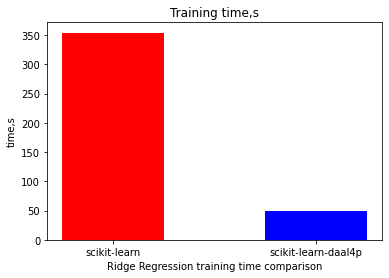

speedup: 7.191686636040115


In [25]:
left = [1,2]
pred_times = [time_nodaal,time_daal ]
tick_label = ['scikit-learn', 'scikit-learn-daal4p']
plt.bar(left, pred_times, tick_label = tick_label, width = 0.5, color = ['red', 'blue'])
plt.xlabel('Ridge Regression training time comparison'); plt.ylabel('time,s'); plt.title('Training time,s')
plt.show()
print("speedup:",time_nodaal/time_daal)